In [2]:
%matplotlib inline
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import os
import datetime
from os.path import join
from nilearn.masking import apply_mask
from nilearn.image import threshold_img,math_img,mean_img
from nilearn import plotting, input_data, image
from scipy.stats import ttest_ind
from scipy.ndimage import morphology,measurements
from nibabel import Nifti1Image

rsn10 = r'C:\github\a_htywork\20170315_autumnROC\PNAS_Smith09_rsn10.nii.gz'
face_dir = r'C:\expdata\ABIDE_2017_drz5000\FACE_drzstat_N1000'
abide_mask_dir = r'C:\expdata\ABIDE_2017_drz5000\ABIDE12_drz5000_mask'
result_dir1 = r'C:\temp\all3'

def safe_mkdir(dirname):
    try:
        os.mkdir(dirname)
        
    except:
        print('mkdir failed!')


def getAuc_P(drz_ff,mask,target):
    try:
        roivalue = np.mean(apply_mask(drz_ff, mask),1)
        fpr, tpr, thresholds = metrics.roc_curve(target, roivalue)
        auc = metrics.auc(fpr, tpr)
        if auc < 0.5:
            fpr, tpr, thresholds = metrics.roc_curve(target, -roivalue)
            auc = metrics.auc(fpr, tpr)
            
        t, p = ttest_ind(roivalue[(target==0).nonzero()[0]],
                             roivalue[(target==1).nonzero()[0]],
                             equal_var=True)

    except BaseException as e:
        roivalue = target*0        
        auc = 0
        t = 0
        p = 1
        
    return roivalue.reshape(-1,1), auc, t, p

def gpstr(p):
    pstr = '%.3f' % p
    if p < 0.05:pstr += '*'
    if p < 0.01:pstr += '*'
    return pstr


def getcluster(abide_mask,t1t2,iternum=1):
    data = morphology.binary_opening(abide_mask.get_data(), iterations=iternum)
    #data = morphology.binary_dilation(data, iterations=1)
    data,labelnum = measurements.label(data)

    if t1t2 =='t1':
        fstr = str(ii+1)
    else:
        fstr = str(ii+11)

    for jjj in range(1,labelnum+1):
        cluster = (data==jjj)
        abide_mask = Nifti1Image(cluster, header=abide_mask.header, affine=abide_mask.affine)
        roivalueA1, aucA1, tA1, pA1 = getAuc_P(facedata_ff,abide_mask,face_target)
        maskt1pxs = abide_mask.get_data().sum()
        if pA1 < 0.05:
            math_img('img1*1.0',img1=abide_mask).to_filename(join(result_dir,'A%smask_cluster%d.nii.gz' % (fstr,jjj)))
            plotting.plot_roi(abide_mask,title='A%s:z%d,%.3f' % (fstr,zthr,pA1), draw_cross=False,
                          output_file = join(result_dir,'A%s_z%s_cluster%d.jpg' % (fstr,zstr,jjj)))
            print('A%s: cluster%d (%d):%.3f(%s)' % \
                  (fstr,jjj,maskt1pxs,aucA1,gpstr(pA1)))
    return labelnum
            
def nii_opening(abide_mask,iternum=1):
    data = morphology.binary_opening(abide_mask.get_data(), iterations=iternum)
    abide_mask = Nifti1Image(data, header=abide_mask.header, affine=abide_mask.affine)
    return abide_mask

C:\Users\tyhua\Anaconda3\lib\site-packages\nilearn\plotting\displays.py:674: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
C:\Users\tyhua\Anaconda3\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RSN01_PVN(10713) AUC: 0.533(0.875)	 t1(2205):0.500(0.931)		 t2(124):0.593(0.188) 
RSN02_OPN(7800) AUC: 0.583(0.637)	 t1(0):0.000(1.000)		 t2(3):0.567(0.220) 
RSN03_LVN(10006) AUC: 0.593(0.176)	 t1(4954):0.607(0.155)		 t2(174):0.617(0.204) 
RSN04_DMN(10002) AUC: 0.609(0.407)	 t1(4258):0.757(0.010*)		 t2(75):0.639(0.069) 
RSN05_CEB(9146) AUC: 0.567(0.091)	 t1(0):0.000(1.000)		 t2(1838):0.628(0.036*) 
RSN06_MOT(9497) AUC: 0.565(0.313)	 t1(48):0.604(0.155)		 t2(2985):0.567(0.229) 
RSN07_AUD(6494) AUC: 0.628(0.124)	 t1(61):0.641(0.231)		 t2(175):0.570(0.304) 
RSN08_ECN(13946) AUC: 0.630(0.131)	 t1(1485):0.617(0.135)		 t2(5585):0.663(0.037*) 
RSN09_RFP(12489) AUC: 0.622(0.041*)	 t1(196):0.546(0.685)		 t2(1498):0.663(0.068) 
RSN10_LFP(11913) AUC: 0.637(0.160)	 t1(186):0.667(0.134)		 t2(827):0.674(0.094) 



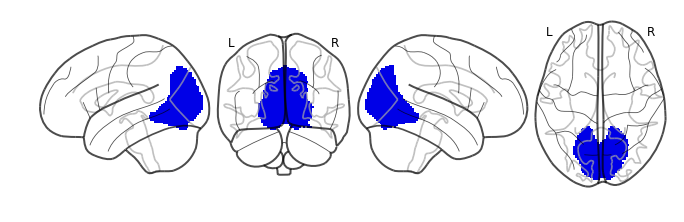

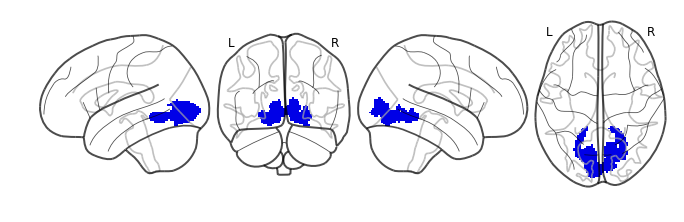

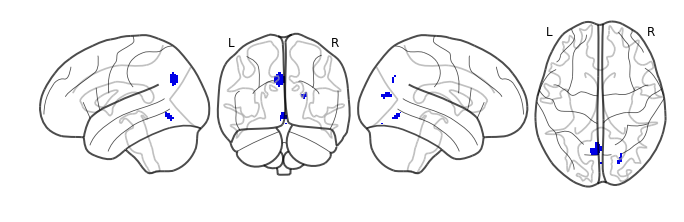

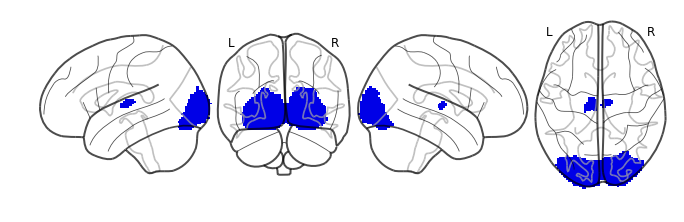

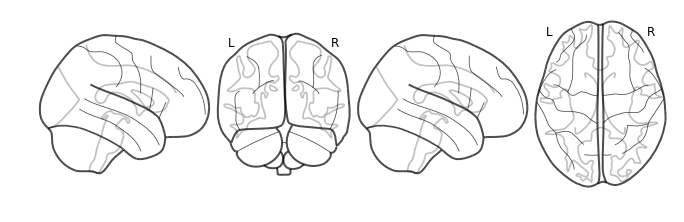

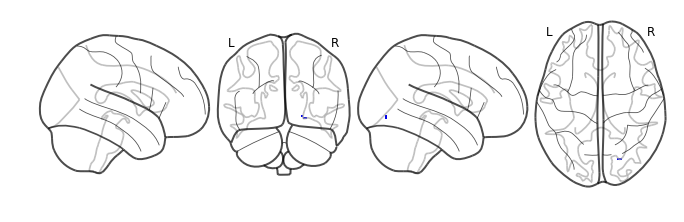

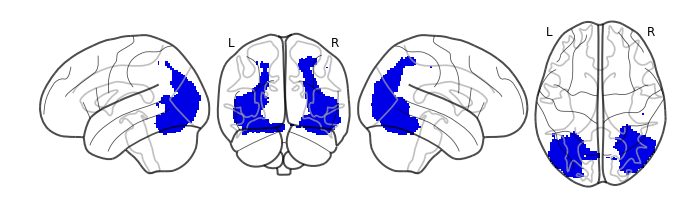

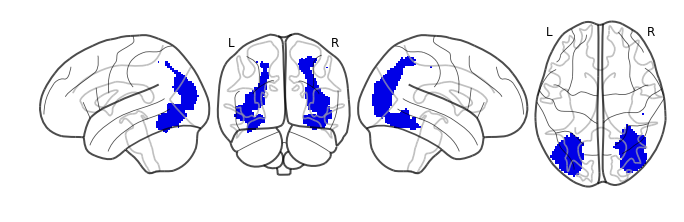

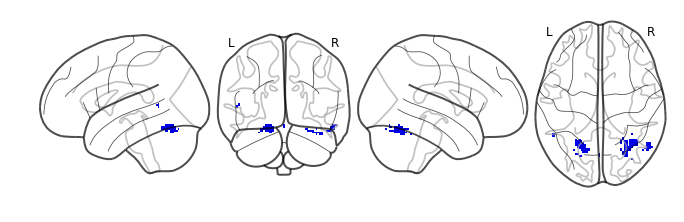

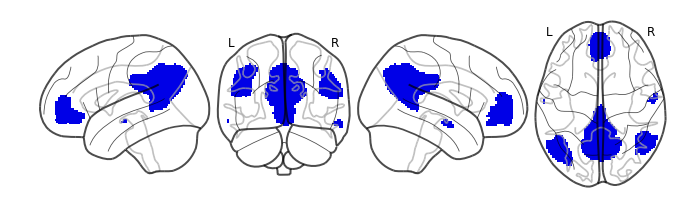

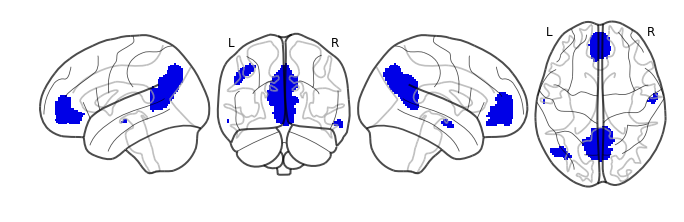

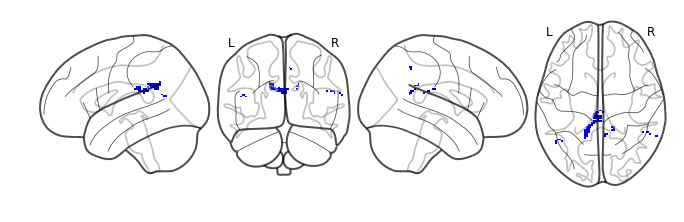

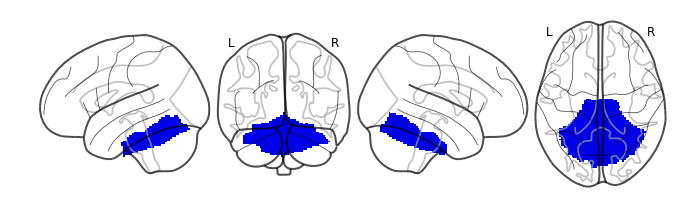

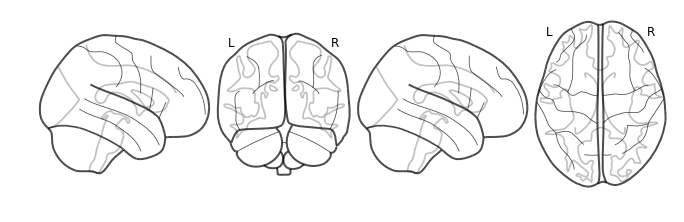

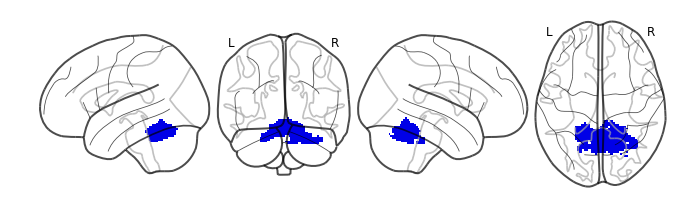

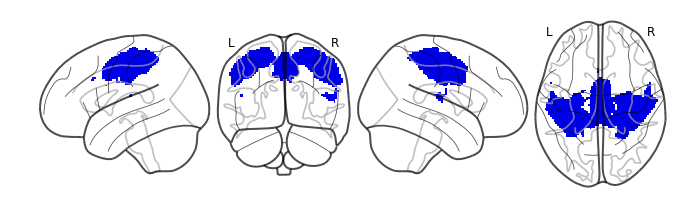

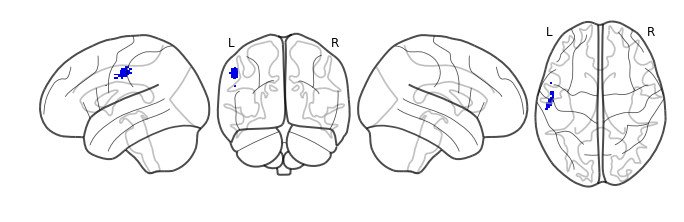

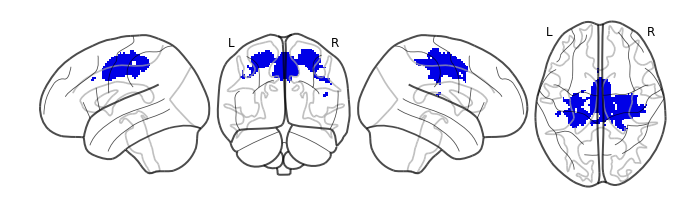

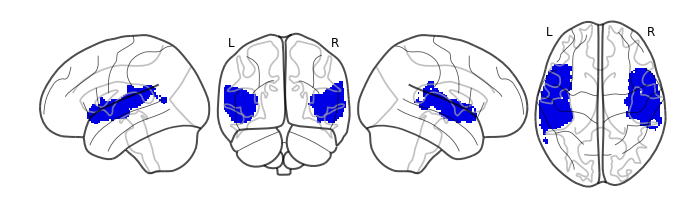

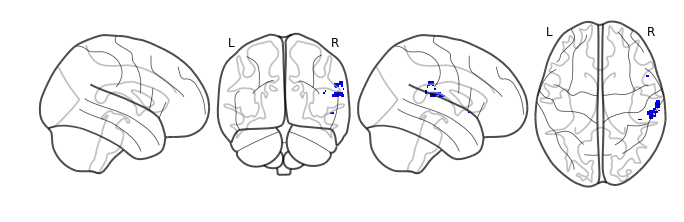

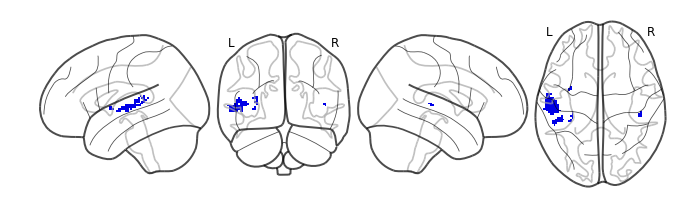

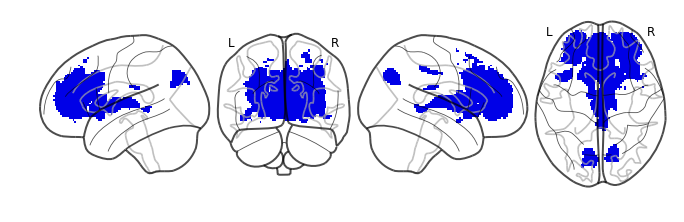

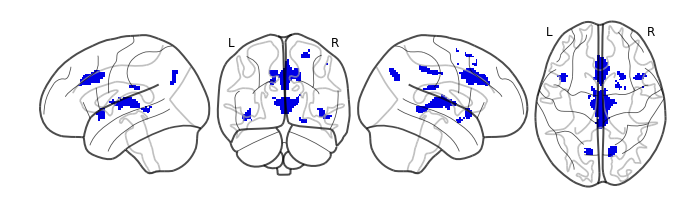

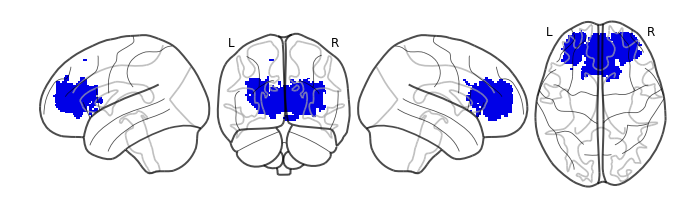

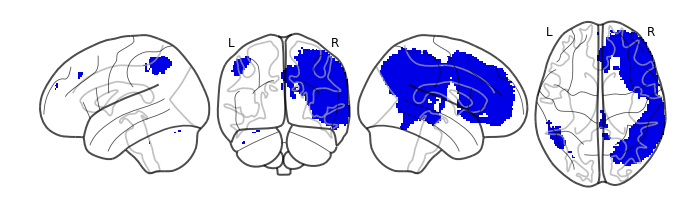

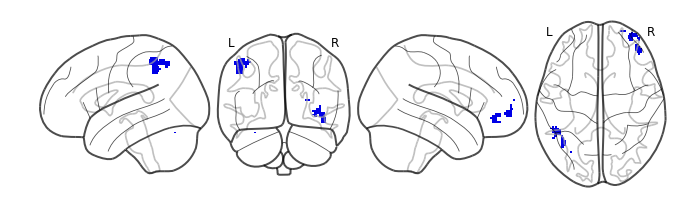

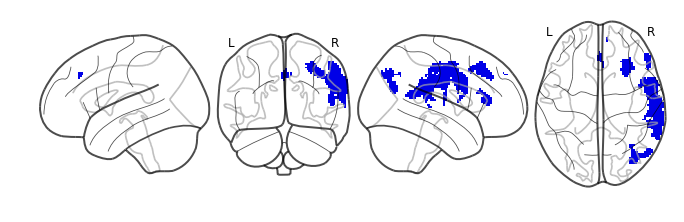

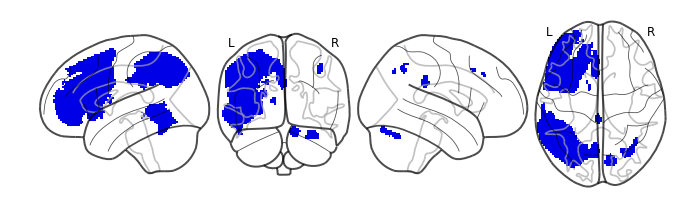

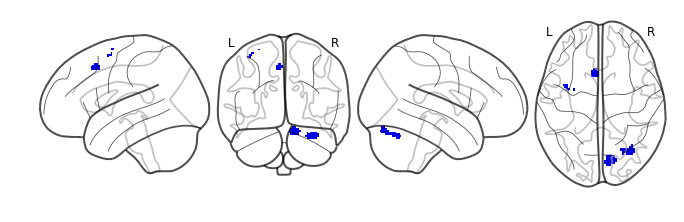

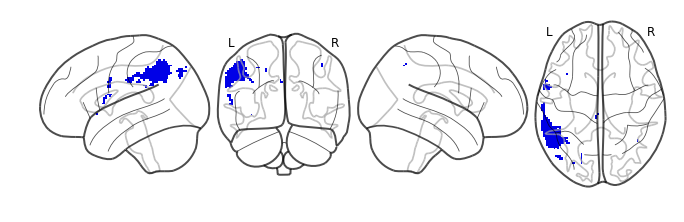

In [58]:
result_dir = join(result_dir1,datetime.datetime.now().strftime("Mask%m%d_%H%M%S"))
safe_mkdir(result_dir)

face_target = np.ones((43,1))
face_target[:23] = 0
zthr = 4
zstr = str(zthr).replace('.','p')
RSNstr = ['PVN','OPN','LVN','DMN','CEB','MOT','AUD','ECN','RFP','LFP']
opening = 0
'''
with open(join(abide_mask_dir,'subjdx.txt'), 'r') as f:
    abide_target = [int(line.strip()) for line in f]
    
    
'''

cords =[(1,-75,7),(0,-91,-3),(38,-69,1),(0,-55,26),(1,-48,-29),(3,-22,49),(-49,-11,4),(1,40,15),(48,-10,27),(-41,26,22)]
RSN_report =''
pxs =[]

def plotpaper(img, output_file):
    #display = plotting.plot_glass_brain(None, display_mode='lyrz')
    #display.add_contours(img, filled=True, levels=[1], colors='r',linewidths=4.)
    #display.savefig(output_file)
    display = plotting.plot_glass_brain(math_img('img1*-1.0',img1=img), display_mode='lyrz'
                                        ,vmin=-1.5,vmax=1.5,plot_abs=False)
    display.savefig(output_file)


for ii in range(10):
    y = face_target
    facedata_ff = join(face_dir,'rsn%d' % ii,'allRmaps.nii.gz')
    abide_ff = join(abide_mask_dir,'rsn%d' % ii,'allRmaps.nii.gz')
    
    # get RSN mask with Z threshold
    rsnmask =  math_img('img1>=%f' % zthr,img1=image.index_img(rsn10, ii))
    
        
    abide_maskt1_ff =join(abide_mask_dir,'rsn%d' % ii,'twosample_tfce_corrp_tstat1.nii.gz')
    abide_maskt2_ff =join(abide_mask_dir,'rsn%d' % ii,'twosample_tfce_corrp_tstat2.nii.gz')

    abide_maskt1_ff = math_img('img1>=%f' % 0.95,img1=abide_maskt1_ff)
    abide_maskt2_ff = math_img('img1>=%f' % 0.95,img1=abide_maskt2_ff)
    
    abide_maskt1_ff = math_img('img1*img2',img1=rsnmask, img2=abide_maskt1_ff)  
    abide_maskt2_ff = math_img('img1*img2',img1=rsnmask, img2=abide_maskt2_ff)
    

    
    

    
    roivalueR, aucR, tR, pR = getAuc_P(facedata_ff,rsnmask,face_target)
    
    
    # perform opening
    #abide_maskt1_ff = abide_maskt2_ff
    
        

    getcluster(abide_maskt1_ff,'t1',iternum=opening)
    getcluster(abide_maskt2_ff,'t2',iternum=opening)
    
    #abide_maskt1_ff = nii_opening(abide_maskt1_ff,iternum=opening)
    #abide_maskt2_ff = nii_opening(abide_maskt2_ff,iternum=opening)
    
    math_img('img1*1.0',img1=rsnmask).to_filename(join(result_dir,'R%02dmask.nii.gz' % (ii+1)))
    math_img('img1*1.0',img1=abide_maskt1_ff).to_filename(join(result_dir,'A%02dmask.nii.gz' % (ii+1)))
    math_img('img1*1.0',img1=abide_maskt2_ff).to_filename(join(result_dir,'A%02dmask.nii.gz' % (ii+11)))

    
    roivalueR, aucR, tR, pR = getAuc_P(facedata_ff,rsnmask,face_target)
    roivalueA1, aucA1, tA1, pA1 = getAuc_P(facedata_ff,abide_maskt1_ff,face_target)
    roivalueA2, aucA2, tA2, pA2 = getAuc_P(facedata_ff,abide_maskt2_ff,face_target)
    '''
    plotting.plot_roi(rsnmask, cut_coords=cords[ii],
                  output_file = join(result_dir,'RSN%d.jpg' % (ii+1)),
                 annotate=True, black_bg=True, draw_cross = False)

    plotting.plot_roi(abide_maskt1_ff,cut_coords=cords[ii],
                      output_file = join(result_dir,'RSN%d_t1.jpg' % (ii+1)),
                     annotate=False, black_bg=True, draw_cross = False)
    plotting.plot_roi(abide_maskt2_ff, cut_coords=cords[ii],
                      output_file = join(result_dir,'RSN%d_t2.jpg' % (ii+1)),
                     annotate=False, black_bg=True, draw_cross = False)
    '''

    plotpaper(rsnmask, output_file = join(result_dir,'RSN%d.jpg' % (ii+1)))

    plotpaper(abide_maskt1_ff, output_file = join(result_dir,'RSN%d_t1.jpg' % (ii+1)))
    plotpaper(abide_maskt2_ff, output_file = join(result_dir,'RSN%d_t2.jpg' % (ii+1)))
    

    

    rsnmaskpxs = rsnmask.get_data().sum()
    maskt1pxs = abide_maskt1_ff.get_data().sum()
    maskt2pxs = abide_maskt2_ff.get_data().sum()

    RSN_report += ('RSN%02d_%s(%d) AUC: %.3f(%s)\t t1(%d):%.3f(%s)\t\t t2(%d):%.3f(%s) \n' % \
          (ii+1,RSNstr[ii],
           rsnmaskpxs,aucR,gpstr(pR),
           maskt1pxs,aucA1,gpstr(pA1),
           maskt2pxs,aucA2,gpstr(pA2)))


    pxs.append([rsnmaskpxs,maskt1pxs,maskt2pxs])
    if ii == 0:
        Rmatrix = roivalueR
        A1matrix = roivalueA1
        A2matrix = roivalueA2
        
    else:
        Rmatrix = np.hstack((Rmatrix,roivalueR))
        A1matrix = np.hstack((A1matrix,roivalueA1))
        A2matrix = np.hstack((A2matrix,roivalueA2))
    

print(RSN_report)

np.savetxt(join(result_dir,'tsall_%s.csv' % zstr),np.hstack((face_target,Rmatrix,A1matrix,A2matrix)),fmt='%.5f', delimiter=',')

C:\Users\tyhua\Anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
C:\Users\tyhua\Anaconda3\lib\site-packages\matplotlib\contour.py:909: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


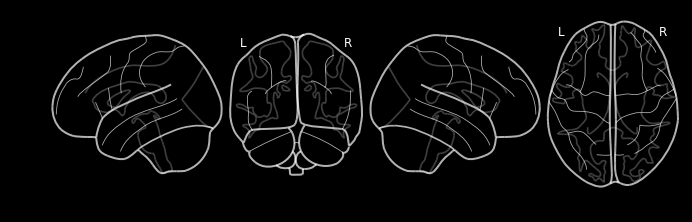

In [49]:
display = plotting.plot_glass_brain(None, display_mode='lyrz',black_bg=True)
display.add_contours(r'C:\temp\all3\Mask0116_135440\A11mask.nii.gz', filled=True, levels=[1], colors='k',linewidths=0.1)
display.savefig(r'c:\temp\glasstest.jpg')